# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [ ]:
# Check if we have a GPU available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [1]:
# Loading the data set shakespeare.txt
dataset = 'downloaded_books/shakespeare.txt'
fraction = 0.1
with open(dataset, 'r', encoding='utf-8') as file:
    raw_text = file.read()
text = raw_text[:int(fraction * len(raw_text))]

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [2]:
#Print the first 1000 characters of the dataset
print("First 1000 characters of the dataset:")
print(text[:1000])

#Report the dataset's size
dataset_size = len(text)
print("\nData set Size (number of  characters): ", dataset_size)

#number of unique characters it contains.
unique_characters = sorted(set(text)) # creating a set to extract unique characters
num_unique_characters = len(unique_characters)
print("Number of unique characters:", num_unique_characters)

First 1000 characters of the dataset:
The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [3]:
import re
from collections import Counter

# Tokenize the text into words using regex to find words (handles punctuation)
words = re.findall(r'\b\w+\b', text)

# Count the frequency of each word
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(10)  # Adjust the number as needed

# Print the most common words and their counts
print("Most common words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most common words:
the: 5676
and: 3874
of: 3593
to: 3350
_: 3026
a: 2403
I: 2236
in: 2053
that: 1512
you: 1512


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

VOCAB_SIZE = 5676
OOV_TOKEN = "<OOV>"

# Convert the entire text to lowercase.
text = text.lower()

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(f'Example of word_index: {list(word_index.items())[:5]}')

Found 13218 unique tokens.
Example of word_index: [('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5)]


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [5]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [6]:

SEQ_LENGTH = 50 

# Convert the text to sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate training sequences
X = []
y = []

# Loop through the sequences to create input-output pairs
for i in range(len(sequences) - SEQ_LENGTH):
    # Create the input sequence of token IDs
    input_seq = sequences[i:i + SEQ_LENGTH]
    # The target token is the token immediately following the input sequence
    target_token = sequences[i + SEQ_LENGTH]
    
    # Append the input sequence and target token to the lists
    X.append(input_seq)
    y.append(target_token)



In [7]:
import numpy as np
# Split the text into sentences (you can adjust the delimiter as needed)
sentences = text.split('.')  # Using '.' as a delimiter
lengths = [len(sentence.split()) for sentence in sentences]

# Print statistics about sentence lengths
print("Average sentence length:", np.mean(lengths))
print("Max sentence length:", max(lengths))
print("Min sentence length:", min(lengths))
print("Length distribution:", np.histogram(lengths, bins=20))

Average sentence length: 9.886535457669478
Max sentence length: 293
Min sentence length: 0
Length distribution: (array([12239,  2369,   889,   300,   108,    58,    20,    13,     1,
           2,     1,     1,     2,     0,     0,     0,     0,     0,
           1,     1]), array([  0.  ,  14.65,  29.3 ,  43.95,  58.6 ,  73.25,  87.9 , 102.55,
       117.2 , 131.85, 146.5 , 161.15, 175.8 , 190.45, 205.1 , 219.75,
       234.4 , 249.05, 263.7 , 278.35, 293.  ]))


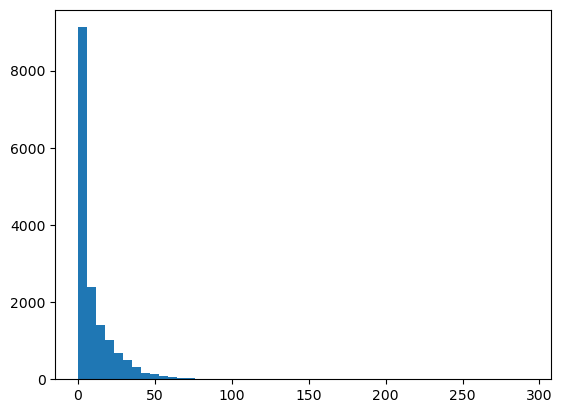

In [8]:
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50);

Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [9]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [2, 56, 54, 411, 4, 107, 28, 668, 172, 20, 411, 13, 16, 2, 176, 4, 669, 1643, 33, 43, 1095, 3, 14, 412, 43, 1790, 1423, 10, 85, 333, 15, 124, 15, 163, 29, 531, 176, 15, 254, 2, 216, 4, 2, 56, 54, 297, 1248, 14, 20, 411]
Target: 29
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook'] -> or


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (117931, 50)
y_train shape: (117931, 5676)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional


model = Sequential([
    Input(shape=(SEQ_LENGTH,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=150),  
    Bidirectional(LSTM(128, return_sequences=True)),  
    LSTM(128),  
    Dense(VOCAB_SIZE, activation='softmax')  
])

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

Loss Function: Categorical Crossentropy - it is suitable for multi-class classification problems, where each input is assigned to one of multiple classes (in this case, predicting the next word in a sequence).

Optimizer: Adam (Adaptive Moment Estimation)

Adam is an adaptive learning rate optimization algorithm that combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. Adam is computationally efficient and requires little memory overhead.

In [20]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy'])

In [21]:
# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 150)        │       851,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       285,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5676)           │       732,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,066,420 (7.88 MB)

 Trainable params: 2,066,420 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [22]:
# Training the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=128)

Epoch 1/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 202s 217ms/step - accuracy: 0.0452 - loss: 7.0885 - val_accuracy: 0.0716 - val_loss: 6.5392
Epoch 2/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 202s 219ms/step - accuracy: 0.0768 - loss: 6.3335 - val_accuracy: 0.0936 - val_loss: 6.2923
Epoch 3/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 199s 216ms/step - accuracy: 0.0980 - loss: 6.0142 - val_accuracy: 0.1038 - val_loss: 6.0926
Epoch 4/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 199s 216ms/step - accuracy: 0.1118 - loss: 5.7246 - val_accuracy: 0.1122 - val_loss: 5.9396
Epoch 5/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 200s 217ms/step - accuracy: 0.1241 - loss: 5.4789 - val_accuracy: 0.1215 - val_loss: 5.9071


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

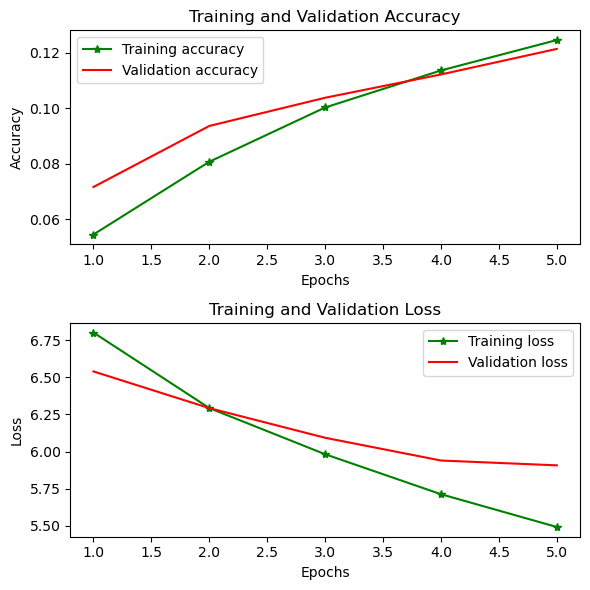

In [23]:
import matplotlib.pyplot as plt

# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Plot training and validation accuracy
ax1.plot(epochs, acc, 'g*-', label='Training accuracy')
ax1.plot(epochs, val_acc, 'r-', label='Validation accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation loss
ax2.plot(epochs, loss, 'g*-', label='Training loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.



In [28]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """
    generated_text = seed_text

    # Continuously generate text until a stop condition is met
    while True:
        # Tokenize the current generated text
        tokenized_text = tokenizer.texts_to_sequences([generated_text])[0]
        
        # Ensure the sequence is of the correct length
        tokenized_text = pad_sequences([tokenized_text], maxlen=max_sequence_len, truncating='pre')
        
        # Get the predicted next word
        predicted_word_index = get_predicted_word(model, tokenized_text)
        
        # Get the word from the index
        predicted_word = tokenizer.index_word.get(predicted_word_index, '')
        
        # If the predicted word is empty or we've generated enough text, stop generating
        if not predicted_word or len(generated_text) > 500:  # Limit total length to 500 characters
            break
            
        # Append the predicted word to the generated text
        generated_text += ' ' + predicted_word

    return generated_text.strip()



In [29]:


# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)


"hamlet h base helicanus luciana 37 ant are deep than bertram indeed if from to his sources exit say either intended into to watch you do no what now what ferdinand by mine textual preceded mother again i'll be killed i'the am wouldst l how he prithee not asked othello we be o nothing give my tongue appears up us meanwhile you should be mated antipholus of without tarsus queen elizabeth sent troilus to sorrow better my king it agree to try so dry was not slept ham o and lost sure up to thy measure"

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [30]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-04 22:56:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.23MB/s    in 2m 45s  

2024-08-04 22:59:29 (4.99 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [31]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

    

Found 400000 word vectors.


In [32]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

                

In [33]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

    

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

# Define a new model with pre-trained embeddings
model = Sequential([
    Input(shape=(SEQ_LENGTH,)),
    Embedding(input_dim=VOCAB_SIZE, 
              output_dim=100, 
              weights=[embedding_matrix], 
              input_length=SEQ_LENGTH, 
              trainable=False),  # Set trainable to False to use pre-trained embeddings
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),  # Dropout layer for regularization
    LSTM(128),
    Dropout(0.2),
    Dense(VOCAB_SIZE, activation='softmax')  
])

# Compile the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy'])

# Training the model
history2 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,  # Increased number of epochs
                    batch_size=64)  # Experimented with a smaller batch size



/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 202s 108ms/step - accuracy: 0.0374 - loss: 7.4388 - val_accuracy: 0.0716 - val_loss: 6.4985
Epoch 2/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 200s 108ms/step - accuracy: 0.0725 - loss: 6.4179 - val_accuracy: 0.0941 - val_loss: 6.2040
Epoch 3/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 201s 109ms/step - accuracy: 0.0899 - loss: 6.0746 - val_accuracy: 0.1091 - val_loss: 5.9467
Epoch 4/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 203s 110ms/step - accuracy: 0.1000 - loss: 5.8332 - val_accuracy: 0.1168 - val_loss: 5.8223
Epoch 5/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 203s 110ms/step - accuracy: 0.1063 - loss: 5.6527 - val_accuracy: 0.1213 - val_loss: 5.7588
Epoch 6/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 202s 110ms/step - accuracy: 0.1111 - loss: 5.5077 - val_accuracy: 0.1275 - val_loss: 5.7299
Epoch 7/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 870s 472ms/step - accuracy: 0.1164 - loss: 5.3974 - val_accuracy: 0.1320 - val_loss: 5.7067
Epoch 8/10
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 198s 108ms/step - ac

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.